[View in Colaboratory](https://colab.research.google.com/github/vvkishere/ubelt/blob/master/Group_6_IDL_Lab.ipynb)

# Introduction To Deep Learning
## Question Statement

1. Load the dataset
2. Prepare the data
    1. Encode the integer sequences into a binary matrix
    2. Vectorise your labels
3. Add the model definition for analysing the data
    Decide – 
    • How many layers to use?
    • How many hidden units to choose for each layer?
    • Which activation function to use?
4. Develop the model to classify the kind of review and judge whether it is positive or negative

In [2]:
# Importing the libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import OneHotEncoder
import keras.utils
from keras.datasets import imdb
from matplotlib import pyplot
from keras.callbacks import ModelCheckpoint

#Load the required libraries
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 1. Load the IMDB dataset
Keep the top 10,000 most frequently occuring words in the training data

In [0]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [4]:
print(train_data.shape, test_data.shape)

(25000,) (25000,)


The test and train datasets are equal in size. We need to run an analysis on the data to see whether we need to modify the data in anyway to improve the models prediction accuracy. We need to concatenate the data and then run our EDA on the same.

In [5]:
#To find the overall characteristics of the data, we need to concatenate the results of train and test
data = np.concatenate((train_data, test_data), axis=0)
labels =np.concatenate((train_labels, test_labels), axis=0) 
#Find the number of records for the train and test sets
print(data.shape)
print(labels.shape)

(50000,)
(50000,)


This is a sufficently large dataset to create a neural network model for a binary classifier.

Review length: 
Mean 234.76 words (172.911495)


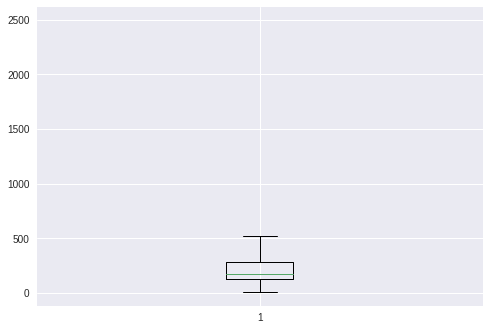

In [6]:
#Summarize review length
print("Review length: ")
result = [len(x) for x in data]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

#Plot review length
pyplot.boxplot(result)
pyplot.show()

In [7]:
# Summarize number of classes
print("Classes:", np.unique(labels))
print(np.unique(labels, return_counts=True))
print("Number of unique words:", len(np.unique(np.hstack(data))))

Classes: [0 1]
(array([0, 1]), array([25000, 25000]))
Number of unique words: 9998


## Data observation
1. The data is not evenly sized and each review is of different length. We need to fix that before we can feed it into the model. We shall cap the review length at 500 words.
2. The words in the dataset are indexed based on their popularity in the overall dataset. We can use that for encoding
3. There are only 2 labels we need to be able to predict in the model. This is a binary classification problem
4. The number of labels are evenly matched in the dataset. We don't have to over sample the data for any one label


## 2. Prepare the data
Encode the integer sequences into a binary matrix

Making the test and training data into evenly sized sequences. This will be important to load into the network

In [0]:
def vectorize(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [9]:
X = vectorize(data)
y = np.array(labels).astype("float32")
print (X.shape)
print (y.shape)

(50000, 10000)
(50000,)


In [10]:
print(X)
print(y)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[1. 0. 0. ... 0. 0. 0.]


In [0]:
X_train = X[25000:]
y_train = y[25000:]

X_test = X[:25000]
y_test = y[:25000]

In [12]:
[X_train.shape,y_train.shape]


[(25000, 10000), (25000,)]

In [13]:
[X_test.shape, y_test.shape]

[(25000, 10000), (25000,)]

## 3. How many layers? How many hidden units to choose for each layer? Which activation function to use?

The question before this is whether a simple neural network would suffice or if a more complicated and computationaly heavy convolutional network would be required.

Consider that a few dense layers might suffice to create a good model, the following model archtecture is being proposed.

*   Input (Embedding) layer with input shape as (25000, 500), activation function to be used is 'relu', and start with around 512 units.
*   1st hidden layer - (Dense) layer with 256 units with activation = 'relu', coupled with a Dropout of around 30%
*   2nd hidden layer - (Dense) layer with 128 units with activation = 'relu', coupled with a Dropout of around 20%
*   3rd hidden layer - (Dense) layer with 64 units with activation = 'relu', coupled with a Dropout of around 10%
*   Final output layer - (Dense) layer with 1 (binary) output, activation = 'sigmoid'

The final activation function will be a sigmoid as it is a binary classifier.

This is the first draft of the network that will need several iterations before we can be sure of adequate model performance. 

### Model Creation: Iterating different models to check on which model gives us the best results

In [14]:
# Creating the model

# Input - Layer
model = Sequential()
model.add(Dense(512, activation = "relu", input_shape=(10000, )))

# Hidden - Layers
#model.add(Dropout(0.3))
model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu"))

# Output- Layer
model.add(Dense(1, activation = "sigmoid"))
model.summary()

filepath="model1weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 5,284,865
Trainable params: 5,284,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

results = model.fit(X_train, 
                    y_train,
                    epochs= 100,
                    callbacks=callbacks_list,
                    batch_size = 512,
                    validation_data = (X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 5s 190us/step - loss: 0.6928 - acc: 0.5156 - val_loss: 0.6896 - val_acc: 0.5523

Epoch 00001: val_acc improved from -inf to 0.55232, saving model to model1weights.hdf5
Epoch 2/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.6874 - acc: 0.5801 - val_loss: 0.6848 - val_acc: 0.6101

Epoch 00002: val_acc improved from 0.55232 to 0.61012, saving model to model1weights.hdf5
Epoch 3/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.6820 - acc: 0.6322 - val_loss: 0.6791 - val_acc: 0.6530

Epoch 00003: val_acc improved from 0.61012 to 0.65300, saving model to model1weights.hdf5
Epoch 4/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.6752 - acc: 0.6758 - val_loss: 0.6716 - val_acc: 0.6907

Epoch 00004: val_acc improved from 0.65300 to 0.69068, saving model to model1weights.hdf5
Epoch 5/100
25000/25000 [========

25000/25000 [==============================] - 4s 144us/step - loss: 0.6541 - acc: 0.7389 - val_loss: 0.6476 - val_acc: 0.7454

Epoch 00006: val_acc improved from 0.72056 to 0.74544, saving model to model1weights.hdf5
Epoch 7/100
25000/25000 [==============================] - 4s 141us/step - loss: 0.6374 - acc: 0.7578 - val_loss: 0.6288 - val_acc: 0.7624

Epoch 00007: val_acc improved from 0.74544 to 0.76244, saving model to model1weights.hdf5
Epoch 8/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.6150 - acc: 0.7748 - val_loss: 0.6038 - val_acc: 0.7759

Epoch 00008: val_acc improved from 0.76244 to 0.77588, saving model to model1weights.hdf5
Epoch 9/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.5863 - acc: 0.7861 - val_loss: 0.5731 - val_acc: 0.7866

Epoch 00009: val_acc improved from 0.77588 to 0.78660, saving model to model1weights.hdf5
Epoch 10/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.5524 - a


Epoch 00011: val_acc improved from 0.79816 to 0.80724, saving model to model1weights.hdf5
Epoch 12/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.4798 - acc: 0.8172 - val_loss: 0.4704 - val_acc: 0.8140

Epoch 00012: val_acc improved from 0.80724 to 0.81400, saving model to model1weights.hdf5
Epoch 13/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.4468 - acc: 0.8272 - val_loss: 0.4414 - val_acc: 0.8221

Epoch 00013: val_acc improved from 0.81400 to 0.82208, saving model to model1weights.hdf5
Epoch 14/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.4183 - acc: 0.8361 - val_loss: 0.4175 - val_acc: 0.8296

Epoch 00014: val_acc improved from 0.82208 to 0.82956, saving model to model1weights.hdf5
Epoch 15/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.3944 - acc: 0.8445 - val_loss: 0.3984 - val_acc: 0.8366

Epoch 00015: val_acc improved from 0.82956 to 0.83656, saving model to mode

25000/25000 [==============================] - 4s 143us/step - loss: 0.3571 - acc: 0.8572 - val_loss: 0.3704 - val_acc: 0.8449

Epoch 00017: val_acc improved from 0.84036 to 0.84492, saving model to model1weights.hdf5
Epoch 18/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.3426 - acc: 0.8628 - val_loss: 0.3594 - val_acc: 0.8493

Epoch 00018: val_acc improved from 0.84492 to 0.84932, saving model to model1weights.hdf5
Epoch 19/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.3300 - acc: 0.8675 - val_loss: 0.3515 - val_acc: 0.8510

Epoch 00019: val_acc improved from 0.84932 to 0.85096, saving model to model1weights.hdf5
Epoch 20/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.3189 - acc: 0.8737 - val_loss: 0.3442 - val_acc: 0.8546

Epoch 00020: val_acc improved from 0.85096 to 0.85456, saving model to model1weights.hdf5
Epoch 21/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.3090 


Epoch 00022: val_acc improved from 0.85768 to 0.86092, saving model to model1weights.hdf5
Epoch 23/100
25000/25000 [==============================] - 4s 141us/step - loss: 0.2910 - acc: 0.8851 - val_loss: 0.3271 - val_acc: 0.8634

Epoch 00023: val_acc improved from 0.86092 to 0.86340, saving model to model1weights.hdf5
Epoch 24/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.2831 - acc: 0.8881 - val_loss: 0.3226 - val_acc: 0.8647

Epoch 00024: val_acc improved from 0.86340 to 0.86468, saving model to model1weights.hdf5
Epoch 25/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.2755 - acc: 0.8906 - val_loss: 0.3205 - val_acc: 0.8652

Epoch 00025: val_acc improved from 0.86468 to 0.86520, saving model to model1weights.hdf5
Epoch 26/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.2689 - acc: 0.8939 - val_loss: 0.3158 - val_acc: 0.8685

Epoch 00026: val_acc improved from 0.86520 to 0.86848, saving model to mode

25000/25000 [==============================] - 4s 143us/step - loss: 0.2563 - acc: 0.8992 - val_loss: 0.3120 - val_acc: 0.8720

Epoch 00028: val_acc improved from 0.87040 to 0.87200, saving model to model1weights.hdf5
Epoch 29/100
25000/25000 [==============================] - 4s 141us/step - loss: 0.2505 - acc: 0.9025 - val_loss: 0.3091 - val_acc: 0.8710

Epoch 00029: val_acc did not improve from 0.87200
Epoch 30/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.2459 - acc: 0.9037 - val_loss: 0.3073 - val_acc: 0.8718

Epoch 00030: val_acc did not improve from 0.87200
Epoch 31/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.2403 - acc: 0.9064 - val_loss: 0.3050 - val_acc: 0.8737

Epoch 00031: val_acc improved from 0.87200 to 0.87372, saving model to model1weights.hdf5
Epoch 32/100
25000/25000 [==============================] - 4s 140us/step - loss: 0.2354 - acc: 0.9075 - val_loss: 0.3106 - val_acc: 0.8741

Epoch 00032: val_acc improve

25000/25000 [==============================] - 4s 140us/step - loss: 0.2259 - acc: 0.9132 - val_loss: 0.3029 - val_acc: 0.8766

Epoch 00034: val_acc improved from 0.87572 to 0.87664, saving model to model1weights.hdf5
Epoch 35/100
25000/25000 [==============================] - 3s 140us/step - loss: 0.2218 - acc: 0.9142 - val_loss: 0.3038 - val_acc: 0.8747

Epoch 00035: val_acc did not improve from 0.87664
Epoch 36/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.2183 - acc: 0.9159 - val_loss: 0.3023 - val_acc: 0.8779

Epoch 00036: val_acc improved from 0.87664 to 0.87792, saving model to model1weights.hdf5
Epoch 37/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.2134 - acc: 0.9184 - val_loss: 0.3028 - val_acc: 0.8764

Epoch 00037: val_acc did not improve from 0.87792
Epoch 38/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.2103 - acc: 0.9194 - val_loss: 0.3059 - val_acc: 0.8760

Epoch 00038: val_acc did not

25000/25000 [==============================] - 3s 139us/step - loss: 0.2023 - acc: 0.9227 - val_loss: 0.3001 - val_acc: 0.8791

Epoch 00040: val_acc improved from 0.87816 to 0.87912, saving model to model1weights.hdf5
Epoch 41/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1987 - acc: 0.9235 - val_loss: 0.3046 - val_acc: 0.8770

Epoch 00041: val_acc did not improve from 0.87912
Epoch 42/100
25000/25000 [==============================] - 3s 138us/step - loss: 0.1962 - acc: 0.9247 - val_loss: 0.3012 - val_acc: 0.8783

Epoch 00042: val_acc did not improve from 0.87912
Epoch 43/100
25000/25000 [==============================] - 3s 140us/step - loss: 0.1926 - acc: 0.9267 - val_loss: 0.3012 - val_acc: 0.8795

Epoch 00043: val_acc improved from 0.87912 to 0.87952, saving model to model1weights.hdf5
Epoch 44/100
25000/25000 [==============================] - 3s 140us/step - loss: 0.1888 - acc: 0.9288 - val_loss: 0.3018 - val_acc: 0.8798

Epoch 00044: val_acc improve

25000/25000 [==============================] - 3s 139us/step - loss: 0.1829 - acc: 0.9313 - val_loss: 0.3025 - val_acc: 0.8801

Epoch 00046: val_acc improved from 0.87980 to 0.88012, saving model to model1weights.hdf5
Epoch 47/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1811 - acc: 0.9314 - val_loss: 0.3033 - val_acc: 0.8795

Epoch 00047: val_acc did not improve from 0.88012
Epoch 48/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1764 - acc: 0.9331 - val_loss: 0.3204 - val_acc: 0.8730

Epoch 00048: val_acc did not improve from 0.88012
Epoch 49/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1739 - acc: 0.9344 - val_loss: 0.3153 - val_acc: 0.8752

Epoch 00049: val_acc did not improve from 0.88012
Epoch 50/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1701 - acc: 0.9364 - val_loss: 0.3085 - val_acc: 0.8786

Epoch 00050: val_acc did not improve from 0.88012
Epoch 51/100
25000

25000/25000 [==============================] - 3s 137us/step - loss: 0.1649 - acc: 0.9385 - val_loss: 0.3075 - val_acc: 0.8800

Epoch 00052: val_acc did not improve from 0.88012
Epoch 53/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1647 - acc: 0.9372 - val_loss: 0.3226 - val_acc: 0.8735

Epoch 00053: val_acc did not improve from 0.88012
Epoch 54/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1619 - acc: 0.9390 - val_loss: 0.3117 - val_acc: 0.8790

Epoch 00054: val_acc did not improve from 0.88012
Epoch 55/100
25000/25000 [==============================] - 3s 138us/step - loss: 0.1610 - acc: 0.9400 - val_loss: 0.3116 - val_acc: 0.8790

Epoch 00055: val_acc did not improve from 0.88012
Epoch 56/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1545 - acc: 0.9439 - val_loss: 0.3317 - val_acc: 0.8713

Epoch 00056: val_acc did not improve from 0.88012
Epoch 57/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 139us/step - loss: 0.1507 - acc: 0.9455 - val_loss: 0.3206 - val_acc: 0.8773

Epoch 00058: val_acc did not improve from 0.88012
Epoch 59/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1469 - acc: 0.9467 - val_loss: 0.3172 - val_acc: 0.8787

Epoch 00059: val_acc did not improve from 0.88012
Epoch 60/100
25000/25000 [==============================] - 3s 138us/step - loss: 0.1460 - acc: 0.9475 - val_loss: 0.3254 - val_acc: 0.8766

Epoch 00060: val_acc did not improve from 0.88012
Epoch 61/100
25000/25000 [==============================] - 4s 140us/step - loss: 0.1430 - acc: 0.9482 - val_loss: 0.3216 - val_acc: 0.8782

Epoch 00061: val_acc did not improve from 0.88012
Epoch 62/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1413 - acc: 0.9493 - val_loss: 0.3234 - val_acc: 0.8779

Epoch 00062: val_acc did not improve from 0.88012
Epoch 63/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 139us/step - loss: 0.1371 - acc: 0.9505 - val_loss: 0.3308 - val_acc: 0.8765

Epoch 00064: val_acc did not improve from 0.88012
Epoch 65/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1413 - acc: 0.9480 - val_loss: 0.3342 - val_acc: 0.8751

Epoch 00065: val_acc did not improve from 0.88012
Epoch 66/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1308 - acc: 0.9540 - val_loss: 0.3261 - val_acc: 0.8784

Epoch 00066: val_acc did not improve from 0.88012
Epoch 67/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1281 - acc: 0.9547 - val_loss: 0.3383 - val_acc: 0.8752

Epoch 00067: val_acc did not improve from 0.88012
Epoch 68/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1309 - acc: 0.9524 - val_loss: 0.3554 - val_acc: 0.8689

Epoch 00068: val_acc did not improve from 0.88012
Epoch 69/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 138us/step - loss: 0.1378 - acc: 0.9487 - val_loss: 0.3366 - val_acc: 0.8764

Epoch 00070: val_acc did not improve from 0.88012
Epoch 71/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1213 - acc: 0.9587 - val_loss: 0.3357 - val_acc: 0.8783

Epoch 00071: val_acc did not improve from 0.88012
Epoch 72/100
25000/25000 [==============================] - 3s 138us/step - loss: 0.1162 - acc: 0.9611 - val_loss: 0.3368 - val_acc: 0.8769

Epoch 00072: val_acc did not improve from 0.88012
Epoch 73/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1200 - acc: 0.9579 - val_loss: 0.3388 - val_acc: 0.8768

Epoch 00073: val_acc did not improve from 0.88012
Epoch 74/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1186 - acc: 0.9579 - val_loss: 0.3422 - val_acc: 0.8762

Epoch 00074: val_acc did not improve from 0.88012
Epoch 75/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 139us/step - loss: 0.1134 - acc: 0.9605 - val_loss: 0.3639 - val_acc: 0.8702

Epoch 00076: val_acc did not improve from 0.88012
Epoch 77/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.2802 - acc: 0.8966 - val_loss: 0.4399 - val_acc: 0.8470

Epoch 00077: val_acc did not improve from 0.88012
Epoch 78/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1135 - acc: 0.9596 - val_loss: 0.3715 - val_acc: 0.8686

Epoch 00078: val_acc did not improve from 0.88012
Epoch 79/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1070 - acc: 0.9647 - val_loss: 0.3701 - val_acc: 0.8694

Epoch 00079: val_acc did not improve from 0.88012
Epoch 80/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1146 - acc: 0.9604 - val_loss: 0.3456 - val_acc: 0.8778

Epoch 00080: val_acc did not improve from 0.88012
Epoch 81/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 139us/step - loss: 0.0986 - acc: 0.9687 - val_loss: 0.3516 - val_acc: 0.8768

Epoch 00082: val_acc did not improve from 0.88012
Epoch 83/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.0980 - acc: 0.9687 - val_loss: 0.3529 - val_acc: 0.8771

Epoch 00083: val_acc did not improve from 0.88012
Epoch 84/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1000 - acc: 0.9676 - val_loss: 0.3586 - val_acc: 0.8755

Epoch 00084: val_acc did not improve from 0.88012
Epoch 85/100
25000/25000 [==============================] - 3s 139us/step - loss: 0.1000 - acc: 0.9663 - val_loss: 0.3582 - val_acc: 0.8766

Epoch 00085: val_acc did not improve from 0.88012
Epoch 86/100
25000/25000 [==============================] - 3s 140us/step - loss: 0.0921 - acc: 0.9714 - val_loss: 0.3604 - val_acc: 0.8761

Epoch 00086: val_acc did not improve from 0.88012
Epoch 87/100
25000/25000 [==============================] 

25000/25000 [==============================] - 3s 138us/step - loss: 0.2764 - acc: 0.9145 - val_loss: 0.3733 - val_acc: 0.8730

Epoch 00088: val_acc did not improve from 0.88012
Epoch 89/100
25000/25000 [==============================] - 3s 140us/step - loss: 0.0898 - acc: 0.9726 - val_loss: 0.3572 - val_acc: 0.8771

Epoch 00089: val_acc did not improve from 0.88012
Epoch 90/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.0850 - acc: 0.9757 - val_loss: 0.3603 - val_acc: 0.8768

Epoch 00090: val_acc did not improve from 0.88012
Epoch 91/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.0826 - acc: 0.9773 - val_loss: 0.3917 - val_acc: 0.8676

Epoch 00091: val_acc did not improve from 0.88012
Epoch 92/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.0820 - acc: 0.9777 - val_loss: 0.3657 - val_acc: 0.8765

Epoch 00092: val_acc did not improve from 0.88012
Epoch 93/100
25000/25000 [==============================] 

25000/25000 [==============================] - 4s 144us/step - loss: 0.0777 - acc: 0.9790 - val_loss: 0.3809 - val_acc: 0.8732

Epoch 00094: val_acc did not improve from 0.88012
Epoch 95/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.0820 - acc: 0.9752 - val_loss: 0.4137 - val_acc: 0.8630

Epoch 00095: val_acc did not improve from 0.88012
Epoch 96/100
25000/25000 [==============================] - 4s 143us/step - loss: 0.0823 - acc: 0.9749 - val_loss: 0.3858 - val_acc: 0.8715

Epoch 00096: val_acc did not improve from 0.88012
Epoch 97/100
25000/25000 [==============================] - 4s 142us/step - loss: 0.3014 - acc: 0.8994 - val_loss: 0.3671 - val_acc: 0.8771

Epoch 00097: val_acc did not improve from 0.88012
Epoch 98/100
25000/25000 [==============================] - 4s 141us/step - loss: 0.0766 - acc: 0.9791 - val_loss: 0.3796 - val_acc: 0.8721

Epoch 00098: val_acc did not improve from 0.88012
Epoch 99/100
25000/25000 [==============================] 

25000/25000 [==============================] - 4s 143us/step - loss: 0.0697 - acc: 0.9833 - val_loss: 0.3764 - val_acc: 0.8757

Epoch 00100: val_acc did not improve from 0.88012


In [16]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

25000/25000 [==============================] - 4s 143us/step
Accuracy: 87.57%


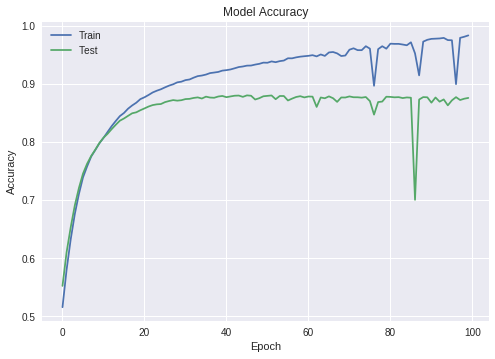

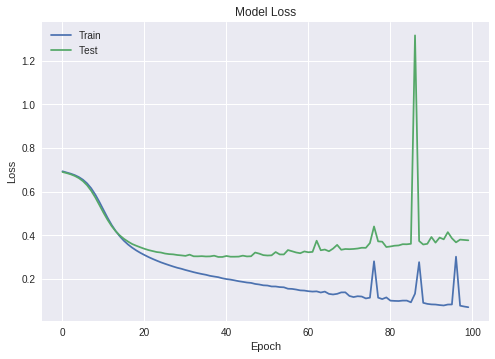

In [17]:
#Summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
# Creating the second model - Increasing input size and adding 1 more layer

# Input - Layer
model2 = Sequential()
model2.add(Dense(1024, activation = "relu", input_shape=(10000, )))

# Hidden - Layers
model2.add(Dense(512, activation = "relu"))
#model.add(Dropout(0.3))
model2.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.2))
model2.add(Dense(128, activation = "relu"))
#model.add(Dropout(0.2))
model2.add(Dense(64, activation = "relu"))

# Output- Layer
model2.add(Dense(1, activation = "sigmoid"))
model2.summary()

filepath="model2weights.hdf5"
checkpoint2 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_24 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 10,938,369
Trainable params: 10,938,369
Non-trainable params: 0
________________________________________________________________

In [27]:
model2.compile(optimizer = "sgd",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

results2 = model2.fit(X_train, 
                    y_train,
                    epochs= 100,
                    batch_size = 512,
                    callbacks=callbacks_list2,
                    validation_data = (X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 5s 187us/step - loss: 0.6926 - acc: 0.5144 - val_loss: 0.6919 - val_acc: 0.5266

Epoch 00001: val_acc improved from -inf to 0.52664, saving model to model2weights.hdf5
Epoch 2/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.6904 - acc: 0.5584 - val_loss: 0.6899 - val_acc: 0.5667

Epoch 00002: val_acc improved from 0.52664 to 0.56668, saving model to model2weights.hdf5
Epoch 3/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.6879 - acc: 0.5991 - val_loss: 0.6873 - val_acc: 0.6078

Epoch 00003: val_acc improved from 0.56668 to 0.60776, saving model to model2weights.hdf5
Epoch 4/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.6846 - acc: 0.6394 - val_loss: 0.6838 - val_acc: 0.6436

Epoch 00004: val_acc improved from 0.60776 to 0.64356, saving model to model2weights.hdf5
Epoch 5/100
 2560/25000 [==>.....

25000/25000 [==============================] - 4s 169us/step - loss: 0.6801 - acc: 0.6721 - val_loss: 0.6789 - val_acc: 0.6705

Epoch 00005: val_acc improved from 0.64356 to 0.67048, saving model to model2weights.hdf5
Epoch 6/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.6739 - acc: 0.7012 - val_loss: 0.6720 - val_acc: 0.6974

Epoch 00006: val_acc improved from 0.67048 to 0.69740, saving model to model2weights.hdf5
Epoch 7/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.6652 - acc: 0.7252 - val_loss: 0.6619 - val_acc: 0.7192

Epoch 00007: val_acc improved from 0.69740 to 0.71924, saving model to model2weights.hdf5
Epoch 8/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.6522 - acc: 0.7444 - val_loss: 0.6467 - val_acc: 0.7389

Epoch 00008: val_acc improved from 0.71924 to 0.73892, saving model to model2weights.hdf5
Epoch 9/100
 8192/25000 [========>.....................] - ETA: 1s - loss: 0.6404 - acc: 0.7

25000/25000 [==============================] - 4s 169us/step - loss: 0.6325 - acc: 0.7622 - val_loss: 0.6234 - val_acc: 0.7538

Epoch 00009: val_acc improved from 0.73892 to 0.75384, saving model to model2weights.hdf5
Epoch 10/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.6024 - acc: 0.7760 - val_loss: 0.5888 - val_acc: 0.7712

Epoch 00010: val_acc improved from 0.75384 to 0.77120, saving model to model2weights.hdf5
Epoch 11/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.5597 - acc: 0.7914 - val_loss: 0.5416 - val_acc: 0.7874

Epoch 00011: val_acc improved from 0.77120 to 0.78740, saving model to model2weights.hdf5
Epoch 12/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.5065 - acc: 0.8096 - val_loss: 0.4888 - val_acc: 0.8053

Epoch 00012: val_acc improved from 0.78740 to 0.80532, saving model to model2weights.hdf5
Epoch 13/100
 8192/25000 [========>.....................] - ETA: 1s - loss: 0.4733 - acc:

25000/25000 [==============================] - 4s 169us/step - loss: 0.4523 - acc: 0.8243 - val_loss: 0.4445 - val_acc: 0.8182

Epoch 00013: val_acc improved from 0.80532 to 0.81820, saving model to model2weights.hdf5
Epoch 14/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.4063 - acc: 0.8379 - val_loss: 0.4059 - val_acc: 0.8309

Epoch 00014: val_acc improved from 0.81820 to 0.83092, saving model to model2weights.hdf5
Epoch 15/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.3716 - acc: 0.8482 - val_loss: 0.3812 - val_acc: 0.8382

Epoch 00015: val_acc improved from 0.83092 to 0.83816, saving model to model2weights.hdf5
Epoch 16/100
25000/25000 [==============================] - 4s 170us/step - loss: 0.3442 - acc: 0.8612 - val_loss: 0.3648 - val_acc: 0.8442

Epoch 00016: val_acc improved from 0.83816 to 0.84424, saving model to model2weights.hdf5
Epoch 17/100
 8192/25000 [========>.....................] - ETA: 1s - loss: 0.3349 - acc:

25000/25000 [==============================] - 4s 169us/step - loss: 0.3255 - acc: 0.8673 - val_loss: 0.3636 - val_acc: 0.8448

Epoch 00017: val_acc improved from 0.84424 to 0.84480, saving model to model2weights.hdf5
Epoch 18/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.3077 - acc: 0.8744 - val_loss: 0.3519 - val_acc: 0.8508

Epoch 00018: val_acc improved from 0.84480 to 0.85084, saving model to model2weights.hdf5
Epoch 19/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2920 - acc: 0.8810 - val_loss: 0.3381 - val_acc: 0.8580

Epoch 00019: val_acc improved from 0.85084 to 0.85796, saving model to model2weights.hdf5
Epoch 20/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2777 - acc: 0.8886 - val_loss: 0.3376 - val_acc: 0.8589

Epoch 00020: val_acc improved from 0.85796 to 0.85888, saving model to model2weights.hdf5
Epoch 21/100
 9216/25000 [==========>...................] - ETA: 1s - loss: 0.2609 - acc:

25000/25000 [==============================] - 4s 168us/step - loss: 0.2795 - acc: 0.8884 - val_loss: 0.3430 - val_acc: 0.8558

Epoch 00021: val_acc did not improve from 0.85888
Epoch 22/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.2898 - acc: 0.8806 - val_loss: 0.3261 - val_acc: 0.8640

Epoch 00022: val_acc improved from 0.85888 to 0.86400, saving model to model2weights.hdf5
Epoch 23/100
25000/25000 [==============================] - 4s 170us/step - loss: 0.2501 - acc: 0.9008 - val_loss: 0.3267 - val_acc: 0.8645

Epoch 00023: val_acc improved from 0.86400 to 0.86448, saving model to model2weights.hdf5
Epoch 24/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.2786 - acc: 0.8859 - val_loss: 0.3160 - val_acc: 0.8686

Epoch 00024: val_acc improved from 0.86448 to 0.86860, saving model to model2weights.hdf5
Epoch 25/100
12288/25000 [=============>................] - ETA: 1s - loss: 0.2390 - acc: 0.9030

25000/25000 [==============================] - 4s 168us/step - loss: 0.2578 - acc: 0.8945 - val_loss: 0.3317 - val_acc: 0.8629

Epoch 00025: val_acc did not improve from 0.86860
Epoch 26/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2554 - acc: 0.8970 - val_loss: 0.4324 - val_acc: 0.8208

Epoch 00026: val_acc did not improve from 0.86860
Epoch 27/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.2285 - acc: 0.9089 - val_loss: 0.3144 - val_acc: 0.8718

Epoch 00027: val_acc improved from 0.86860 to 0.87180, saving model to model2weights.hdf5
Epoch 28/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.2675 - acc: 0.8879 - val_loss: 0.3113 - val_acc: 0.8729

Epoch 00028: val_acc improved from 0.87180 to 0.87292, saving model to model2weights.hdf5
Epoch 29/100
15360/25000 [=================>............] - ETA: 0s - loss: 0.2117 - acc: 0.9191

25000/25000 [==============================] - 4s 168us/step - loss: 0.2255 - acc: 0.9120 - val_loss: 0.3200 - val_acc: 0.8709

Epoch 00029: val_acc did not improve from 0.87292
Epoch 30/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.2227 - acc: 0.9121 - val_loss: 0.3062 - val_acc: 0.8767

Epoch 00030: val_acc improved from 0.87292 to 0.87672, saving model to model2weights.hdf5
Epoch 31/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2151 - acc: 0.9148 - val_loss: 0.3207 - val_acc: 0.8725

Epoch 00031: val_acc did not improve from 0.87672
Epoch 32/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2596 - acc: 0.8960 - val_loss: 0.3093 - val_acc: 0.8757

Epoch 00032: val_acc did not improve from 0.87672
Epoch 33/100
15360/25000 [=================>............] - ETA: 0s - loss: 0.1985 - acc: 0.9243

25000/25000 [==============================] - 4s 169us/step - loss: 0.1976 - acc: 0.9247 - val_loss: 0.3725 - val_acc: 0.8522

Epoch 00033: val_acc did not improve from 0.87672
Epoch 34/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1990 - acc: 0.9222 - val_loss: 0.3286 - val_acc: 0.8689

Epoch 00034: val_acc did not improve from 0.87672
Epoch 35/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1963 - acc: 0.9242 - val_loss: 0.3079 - val_acc: 0.8779

Epoch 00035: val_acc improved from 0.87672 to 0.87792, saving model to model2weights.hdf5
Epoch 36/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1808 - acc: 0.9314 - val_loss: 0.3334 - val_acc: 0.8684

Epoch 00036: val_acc did not improve from 0.87792
Epoch 37/100
16384/25000 [==================>...........] - ETA: 0s - loss: 0.2267 - acc: 0.9083

25000/25000 [==============================] - 4s 169us/step - loss: 0.2472 - acc: 0.9022 - val_loss: 0.3130 - val_acc: 0.8770

Epoch 00037: val_acc did not improve from 0.87792
Epoch 38/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1626 - acc: 0.9414 - val_loss: 0.3117 - val_acc: 0.8773

Epoch 00038: val_acc did not improve from 0.87792
Epoch 39/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1540 - acc: 0.9450 - val_loss: 0.3184 - val_acc: 0.8761

Epoch 00039: val_acc did not improve from 0.87792
Epoch 40/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2586 - acc: 0.8928 - val_loss: 0.4132 - val_acc: 0.8384

Epoch 00040: val_acc did not improve from 0.87792
Epoch 41/100
17920/25000 [====================>.........] - ETA: 0s - loss: 0.1575 - acc: 0.9427

25000/25000 [==============================] - 4s 168us/step - loss: 0.1549 - acc: 0.9441 - val_loss: 0.3198 - val_acc: 0.8767

Epoch 00041: val_acc did not improve from 0.87792
Epoch 42/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1432 - acc: 0.9485 - val_loss: 0.3184 - val_acc: 0.8773

Epoch 00042: val_acc did not improve from 0.87792
Epoch 43/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1874 - acc: 0.9278 - val_loss: 0.7453 - val_acc: 0.7394

Epoch 00043: val_acc did not improve from 0.87792
Epoch 44/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1761 - acc: 0.9325 - val_loss: 0.3157 - val_acc: 0.8788

Epoch 00044: val_acc improved from 0.87792 to 0.87876, saving model to model2weights.hdf5
Epoch 45/100
19968/25000 [======================>.......] - ETA: 0s - loss: 0.1310 - acc: 0.9556

25000/25000 [==============================] - 4s 170us/step - loss: 0.1318 - acc: 0.9548 - val_loss: 0.3413 - val_acc: 0.8730

Epoch 00045: val_acc did not improve from 0.87876
Epoch 46/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2532 - acc: 0.9016 - val_loss: 0.3138 - val_acc: 0.8779

Epoch 00046: val_acc did not improve from 0.87876
Epoch 47/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1243 - acc: 0.9599 - val_loss: 0.3326 - val_acc: 0.8730

Epoch 00047: val_acc did not improve from 0.87876
Epoch 48/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1199 - acc: 0.9604 - val_loss: 0.3306 - val_acc: 0.8764

Epoch 00048: val_acc did not improve from 0.87876
Epoch 49/100
18432/25000 [=====================>........] - ETA: 0s - loss: 0.1503 - acc: 0.9454

25000/25000 [==============================] - 4s 168us/step - loss: 0.2328 - acc: 0.9137 - val_loss: 0.3129 - val_acc: 0.8786

Epoch 00049: val_acc did not improve from 0.87876
Epoch 50/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1156 - acc: 0.9636 - val_loss: 0.3240 - val_acc: 0.8779

Epoch 00050: val_acc did not improve from 0.87876
Epoch 51/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1162 - acc: 0.9613 - val_loss: 0.3381 - val_acc: 0.8742

Epoch 00051: val_acc did not improve from 0.87876
Epoch 52/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1029 - acc: 0.9684 - val_loss: 0.3326 - val_acc: 0.8785

Epoch 00052: val_acc did not improve from 0.87876
Epoch 53/100
17920/25000 [====================>.........] - ETA: 0s - loss: 0.2433 - acc: 0.9152

25000/25000 [==============================] - 4s 169us/step - loss: 0.2075 - acc: 0.9274 - val_loss: 0.3236 - val_acc: 0.8785

Epoch 00053: val_acc did not improve from 0.87876
Epoch 54/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0978 - acc: 0.9708 - val_loss: 0.3311 - val_acc: 0.8788

Epoch 00054: val_acc improved from 0.87876 to 0.87884, saving model to model2weights.hdf5
Epoch 55/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0995 - acc: 0.9690 - val_loss: 0.3514 - val_acc: 0.8766

Epoch 00055: val_acc did not improve from 0.87884
Epoch 56/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2169 - acc: 0.9276 - val_loss: 0.3282 - val_acc: 0.8793

Epoch 00056: val_acc improved from 0.87884 to 0.87928, saving model to model2weights.hdf5
Epoch 57/100
15360/25000 [=================>............] - ETA: 0s - loss: 0.0899 - acc: 0.9758

25000/25000 [==============================] - 4s 169us/step - loss: 0.0924 - acc: 0.9732 - val_loss: 0.3369 - val_acc: 0.8791

Epoch 00057: val_acc did not improve from 0.87928
Epoch 58/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1685 - acc: 0.9395 - val_loss: 0.3407 - val_acc: 0.8777

Epoch 00058: val_acc did not improve from 0.87928
Epoch 59/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0846 - acc: 0.9772 - val_loss: 0.3540 - val_acc: 0.8767

Epoch 00059: val_acc did not improve from 0.87928
Epoch 60/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0763 - acc: 0.9797 - val_loss: 0.3483 - val_acc: 0.8779

Epoch 00060: val_acc did not improve from 0.87928
Epoch 61/100
18432/25000 [=====================>........] - ETA: 0s - loss: 0.0691 - acc: 0.9838

25000/25000 [==============================] - 4s 168us/step - loss: 0.0697 - acc: 0.9832 - val_loss: 0.3560 - val_acc: 0.8770

Epoch 00061: val_acc did not improve from 0.87928
Epoch 62/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.2243 - acc: 0.9260 - val_loss: 0.3607 - val_acc: 0.8658

Epoch 00062: val_acc did not improve from 0.87928
Epoch 63/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.0751 - acc: 0.9816 - val_loss: 0.3474 - val_acc: 0.8750

Epoch 00063: val_acc did not improve from 0.87928
Epoch 64/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0651 - acc: 0.9851 - val_loss: 0.3542 - val_acc: 0.8789

Epoch 00064: val_acc did not improve from 0.87928
Epoch 65/100
20992/25000 [========================>.....] - ETA: 0s - loss: 0.0601 - acc: 0.9864

25000/25000 [==============================] - 4s 169us/step - loss: 0.0612 - acc: 0.9863 - val_loss: 0.3641 - val_acc: 0.8782

Epoch 00065: val_acc did not improve from 0.87928
Epoch 66/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.2019 - acc: 0.9317 - val_loss: 0.3419 - val_acc: 0.8797

Epoch 00066: val_acc improved from 0.87928 to 0.87968, saving model to model2weights.hdf5
Epoch 67/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0596 - acc: 0.9878 - val_loss: 0.3633 - val_acc: 0.8742

Epoch 00067: val_acc did not improve from 0.87968
Epoch 68/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0533 - acc: 0.9895 - val_loss: 0.3763 - val_acc: 0.8734

Epoch 00068: val_acc did not improve from 0.87968
Epoch 69/100
15872/25000 [==================>...........] - ETA: 0s - loss: 0.0488 - acc: 0.9910

25000/25000 [==============================] - 4s 168us/step - loss: 0.0493 - acc: 0.9903 - val_loss: 0.3768 - val_acc: 0.8770

Epoch 00069: val_acc did not improve from 0.87968
Epoch 70/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0459 - acc: 0.9916 - val_loss: 0.3852 - val_acc: 0.8761

Epoch 00070: val_acc did not improve from 0.87968
Epoch 71/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0417 - acc: 0.9928 - val_loss: 0.3959 - val_acc: 0.8748

Epoch 00071: val_acc did not improve from 0.87968
Epoch 72/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0398 - acc: 0.9934 - val_loss: 0.4017 - val_acc: 0.8763

Epoch 00072: val_acc did not improve from 0.87968
Epoch 73/100
18944/25000 [=====================>........] - ETA: 0s - loss: 0.0363 - acc: 0.9944

25000/25000 [==============================] - 4s 168us/step - loss: 0.0369 - acc: 0.9942 - val_loss: 0.4088 - val_acc: 0.8760

Epoch 00073: val_acc did not improve from 0.87968
Epoch 74/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0357 - acc: 0.9939 - val_loss: 0.4141 - val_acc: 0.8748

Epoch 00074: val_acc did not improve from 0.87968
Epoch 75/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.1101 - acc: 0.9785 - val_loss: 0.9406 - val_acc: 0.7447

Epoch 00075: val_acc did not improve from 0.87968
Epoch 76/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.1898 - acc: 0.9404 - val_loss: 0.3608 - val_acc: 0.8765

Epoch 00076: val_acc did not improve from 0.87968
Epoch 77/100
18944/25000 [=====================>........] - ETA: 0s - loss: 0.0386 - acc: 0.9950

25000/25000 [==============================] - 4s 168us/step - loss: 0.0383 - acc: 0.9950 - val_loss: 0.3824 - val_acc: 0.8736

Epoch 00077: val_acc did not improve from 0.87968
Epoch 78/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0329 - acc: 0.9960 - val_loss: 0.3938 - val_acc: 0.8757

Epoch 00078: val_acc did not improve from 0.87968
Epoch 79/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0294 - acc: 0.9966 - val_loss: 0.4047 - val_acc: 0.8757

Epoch 00079: val_acc did not improve from 0.87968
Epoch 80/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0270 - acc: 0.9969 - val_loss: 0.4151 - val_acc: 0.8758

Epoch 00080: val_acc did not improve from 0.87968
Epoch 81/100
18944/25000 [=====================>........] - ETA: 0s - loss: 0.0244 - acc: 0.9976

25000/25000 [==============================] - 4s 169us/step - loss: 0.0249 - acc: 0.9972 - val_loss: 0.4252 - val_acc: 0.8744

Epoch 00081: val_acc did not improve from 0.87968
Epoch 82/100
25000/25000 [==============================] - 4s 170us/step - loss: 0.0232 - acc: 0.9977 - val_loss: 0.4312 - val_acc: 0.8747

Epoch 00082: val_acc did not improve from 0.87968
Epoch 83/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0217 - acc: 0.9980 - val_loss: 0.4404 - val_acc: 0.8738

Epoch 00083: val_acc did not improve from 0.87968
Epoch 84/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.0204 - acc: 0.9981 - val_loss: 0.4476 - val_acc: 0.8737

Epoch 00084: val_acc did not improve from 0.87968
Epoch 85/100
19968/25000 [======================>.......] - ETA: 0s - loss: 0.0198 - acc: 0.9984

25000/25000 [==============================] - 4s 168us/step - loss: 0.0192 - acc: 0.9985 - val_loss: 0.4515 - val_acc: 0.8742

Epoch 00085: val_acc did not improve from 0.87968
Epoch 86/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0185 - acc: 0.9984 - val_loss: 0.4574 - val_acc: 0.8739

Epoch 00086: val_acc did not improve from 0.87968
Epoch 87/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0170 - acc: 0.9987 - val_loss: 0.4630 - val_acc: 0.8736

Epoch 00087: val_acc did not improve from 0.87968
Epoch 88/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0162 - acc: 0.9987 - val_loss: 0.4697 - val_acc: 0.8731

Epoch 00088: val_acc did not improve from 0.87968
Epoch 89/100
17920/25000 [====================>.........] - ETA: 0s - loss: 0.0142 - acc: 0.9991

25000/25000 [==============================] - 4s 169us/step - loss: 0.0153 - acc: 0.9989 - val_loss: 0.4746 - val_acc: 0.8731

Epoch 00089: val_acc did not improve from 0.87968
Epoch 90/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0145 - acc: 0.9989 - val_loss: 0.4797 - val_acc: 0.8731

Epoch 00090: val_acc did not improve from 0.87968
Epoch 91/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0137 - acc: 0.9990 - val_loss: 0.4854 - val_acc: 0.8729

Epoch 00091: val_acc did not improve from 0.87968
Epoch 92/100
25000/25000 [==============================] - 4s 167us/step - loss: 0.0129 - acc: 0.9990 - val_loss: 0.4891 - val_acc: 0.8730

Epoch 00092: val_acc did not improve from 0.87968
Epoch 93/100
18944/25000 [=====================>........] - ETA: 0s - loss: 0.0129 - acc: 0.9989

25000/25000 [==============================] - 4s 168us/step - loss: 0.0121 - acc: 0.9991 - val_loss: 0.4946 - val_acc: 0.8723

Epoch 00093: val_acc did not improve from 0.87968
Epoch 94/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0116 - acc: 0.9990 - val_loss: 0.5004 - val_acc: 0.8722

Epoch 00094: val_acc did not improve from 0.87968
Epoch 95/100
25000/25000 [==============================] - 4s 168us/step - loss: 0.0110 - acc: 0.9992 - val_loss: 0.5029 - val_acc: 0.8727

Epoch 00095: val_acc did not improve from 0.87968
Epoch 96/100
25000/25000 [==============================] - 4s 169us/step - loss: 0.0104 - acc: 0.9992 - val_loss: 0.5094 - val_acc: 0.8718

Epoch 00096: val_acc did not improve from 0.87968
Epoch 97/100
19456/25000 [======================>.......] - ETA: 0s - loss: 0.0097 - acc: 0.9992

25000/25000 [==============================] - 4s 168us/step - loss: 0.0099 - acc: 0.9992 - val_loss: 0.5116 - val_acc: 0.8730

Epoch 00097: val_acc did not improve from 0.87968
Epoch 98/100
25000/25000 [==============================] - 4s 170us/step - loss: 0.0095 - acc: 0.9994 - val_loss: 0.5158 - val_acc: 0.8724

Epoch 00098: val_acc did not improve from 0.87968
Epoch 99/100
25000/25000 [==============================] - 4s 171us/step - loss: 0.0090 - acc: 0.9994 - val_loss: 0.5195 - val_acc: 0.8730

Epoch 00099: val_acc did not improve from 0.87968
Epoch 100/100
25000/25000 [==============================] - 4s 170us/step - loss: 0.0086 - acc: 0.9994 - val_loss: 0.5237 - val_acc: 0.8724

Epoch 00100: val_acc did not improve from 0.87968


In [29]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores2[1]*100))

25000/25000 [==============================] - 4s 180us/step
Accuracy: 87.24%


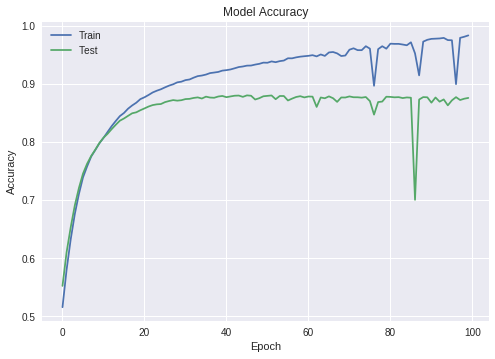

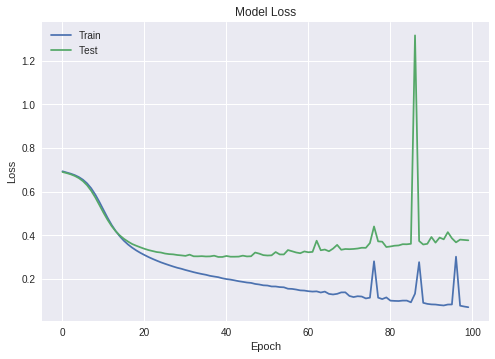

In [30]:
#Summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
# Creating the third model - Reverting to model 1, Adding more layers and changing the optimizer

# Input - Layer
model3 = Sequential()
model3.add(Dense(512, activation = "relu", input_shape=(10000, )))

# Hidden - Layers
#model3.add(layers.Dropout(0.3))
model3.add(Dense(256, activation = "relu"))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation = "relu"))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation = "relu"))
model3.add(Dropout(0.3))
model3.add(Dense(32, activation = "relu"))
# Output- Layer
model3.add(Dense(1, activation = "sigmoid"))
model3.summary()

filepath="model3weights.hdf5"
checkpoint3 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list3 = [checkpoint3]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
__________

In [33]:
model3.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

results3 = model3.fit(X_train, 
                    y_train,
                    epochs= 100,
                    batch_size = 512,
                    callbacks=callbacks_list3,
                    validation_data = (X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 5s 181us/step - loss: 0.4987 - acc: 0.7645 - val_loss: 0.3190 - val_acc: 0.8742

Epoch 00001: val_acc improved from -inf to 0.87416, saving model to model3weights.hdf5
Epoch 2/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.2479 - acc: 0.9050 - val_loss: 0.3168 - val_acc: 0.8754

Epoch 00002: val_acc improved from 0.87416 to 0.87536, saving model to model3weights.hdf5
Epoch 3/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.1660 - acc: 0.9374 - val_loss: 0.3558 - val_acc: 0.8782

Epoch 00003: val_acc improved from 0.87536 to 0.87824, saving model to model3weights.hdf5
Epoch 4/100
25000/25000 [==============================] - 4s 155us/step - loss: 0.1085 - acc: 0.9631 - val_loss: 0.3364 - val_acc: 0.8790

Epoch 00004: val_acc improved from 0.87824 to 0.87900, saving model to model3weights.hdf5
Epoch 5/100
25000/25000 [========

25000/25000 [==============================] - 4s 155us/step - loss: 0.0715 - acc: 0.9898 - val_loss: 0.5505 - val_acc: 0.8773

Epoch 00006: val_acc did not improve from 0.88036
Epoch 7/100
25000/25000 [==============================] - 4s 153us/step - loss: 0.0438 - acc: 0.9916 - val_loss: 0.5808 - val_acc: 0.8788

Epoch 00007: val_acc did not improve from 0.88036
Epoch 8/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0393 - acc: 0.9927 - val_loss: 0.5689 - val_acc: 0.8790

Epoch 00008: val_acc did not improve from 0.88036
Epoch 9/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0015 - acc: 0.9999 - val_loss: 1.0182 - val_acc: 0.8789

Epoch 00009: val_acc did not improve from 0.88036
Epoch 10/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0790 - acc: 0.9916 - val_loss: 0.9103 - val_acc: 0.8802

Epoch 00010: val_acc did not improve from 0.88036
Epoch 11/100
25000/25000 [==============================] - 4

25000/25000 [==============================] - 4s 154us/step - loss: 0.0021 - acc: 0.9999 - val_loss: 0.9353 - val_acc: 0.8789

Epoch 00012: val_acc did not improve from 0.88036
Epoch 13/100
25000/25000 [==============================] - 4s 155us/step - loss: 0.0871 - acc: 0.9898 - val_loss: 0.8303 - val_acc: 0.8776

Epoch 00013: val_acc did not improve from 0.88036
Epoch 14/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.9598 - val_acc: 0.8755

Epoch 00014: val_acc did not improve from 0.88036
Epoch 15/100
25000/25000 [==============================] - 4s 154us/step - loss: 6.6637e-04 - acc: 1.0000 - val_loss: 1.1996 - val_acc: 0.8780

Epoch 00015: val_acc did not improve from 0.88036
Epoch 16/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0693 - acc: 0.9923 - val_loss: 0.9842 - val_acc: 0.8744

Epoch 00016: val_acc did not improve from 0.88036
Epoch 17/100
25000/25000 [============================

25000/25000 [==============================] - 4s 154us/step - loss: 0.0319 - acc: 0.9946 - val_loss: 0.6669 - val_acc: 0.8772

Epoch 00018: val_acc did not improve from 0.88036
Epoch 19/100
25000/25000 [==============================] - 4s 154us/step - loss: 4.1488e-04 - acc: 0.9999 - val_loss: 1.4728 - val_acc: 0.8323

Epoch 00019: val_acc did not improve from 0.88036
Epoch 20/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0389 - acc: 0.9943 - val_loss: 0.8709 - val_acc: 0.8784

Epoch 00020: val_acc did not improve from 0.88036
Epoch 21/100
25000/25000 [==============================] - 4s 153us/step - loss: 0.0415 - acc: 0.9946 - val_loss: 0.8922 - val_acc: 0.8736

Epoch 00021: val_acc did not improve from 0.88036
Epoch 22/100
25000/25000 [==============================] - 4s 155us/step - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5750 - val_acc: 0.7845

Epoch 00022: val_acc did not improve from 0.88036
Epoch 23/100
25000/25000 [============================

25000/25000 [==============================] - 4s 153us/step - loss: 2.9332e-05 - acc: 1.0000 - val_loss: 1.1534 - val_acc: 0.8766

Epoch 00024: val_acc did not improve from 0.88036
Epoch 25/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.5693e-06 - acc: 1.0000 - val_loss: 1.3754 - val_acc: 0.8768

Epoch 00025: val_acc did not improve from 0.88036
Epoch 26/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.8224e-07 - acc: 1.0000 - val_loss: 1.4553 - val_acc: 0.8766

Epoch 00026: val_acc did not improve from 0.88036
Epoch 27/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.2068e-07 - acc: 1.0000 - val_loss: 1.4978 - val_acc: 0.8767

Epoch 00027: val_acc did not improve from 0.88036
Epoch 28/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.1332e-07 - acc: 1.0000 - val_loss: 1.5255 - val_acc: 0.8767

Epoch 00028: val_acc did not improve from 0.88036
Epoch 29/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.1179e-07 - acc: 1.0000 - val_loss: 1.5720 - val_acc: 0.8751

Epoch 00030: val_acc did not improve from 0.88036
Epoch 31/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.1626e-07 - acc: 1.0000 - val_loss: 1.5729 - val_acc: 0.8771

Epoch 00031: val_acc did not improve from 0.88036
Epoch 32/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.1207e-07 - acc: 1.0000 - val_loss: 1.5774 - val_acc: 0.8772

Epoch 00032: val_acc did not improve from 0.88036
Epoch 33/100
25000/25000 [==============================] - 4s 153us/step - loss: 7.8506e-07 - acc: 1.0000 - val_loss: 1.6345 - val_acc: 0.8747

Epoch 00033: val_acc did not improve from 0.88036
Epoch 34/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1041e-07 - acc: 1.0000 - val_loss: 1.6245 - val_acc: 0.8756

Epoch 00034: val_acc did not improve from 0.88036
Epoch 35/100
25000/25000 [============

25000/25000 [==============================] - 4s 155us/step - loss: 1.1090e-07 - acc: 1.0000 - val_loss: 1.6294 - val_acc: 0.8768

Epoch 00036: val_acc did not improve from 0.88036
Epoch 37/100
25000/25000 [==============================] - 4s 156us/step - loss: 1.1017e-07 - acc: 1.0000 - val_loss: 1.6331 - val_acc: 0.8760

Epoch 00037: val_acc did not improve from 0.88036
Epoch 38/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0372 - acc: 0.9966 - val_loss: 1.4932 - val_acc: 0.8736

Epoch 00038: val_acc did not improve from 0.88036
Epoch 39/100
25000/25000 [==============================] - 4s 154us/step - loss: 2.5065e-07 - acc: 1.0000 - val_loss: 1.4922 - val_acc: 0.8740

Epoch 00039: val_acc did not improve from 0.88036
Epoch 40/100
25000/25000 [==============================] - 4s 154us/step - loss: 4.0620e-07 - acc: 1.0000 - val_loss: 1.5977 - val_acc: 0.8687

Epoch 00040: val_acc did not improve from 0.88036
Epoch 41/100
25000/25000 [================

25000/25000 [==============================] - 4s 154us/step - loss: 2.8242e-06 - acc: 1.0000 - val_loss: 1.2674 - val_acc: 0.8735

Epoch 00042: val_acc did not improve from 0.88036
Epoch 43/100
25000/25000 [==============================] - 4s 154us/step - loss: 0.0228 - acc: 0.9971 - val_loss: 1.0229 - val_acc: 0.8769

Epoch 00043: val_acc did not improve from 0.88036
Epoch 44/100
25000/25000 [==============================] - 4s 154us/step - loss: 2.1797e-05 - acc: 1.0000 - val_loss: 1.0514 - val_acc: 0.8759

Epoch 00044: val_acc did not improve from 0.88036
Epoch 45/100
25000/25000 [==============================] - 4s 154us/step - loss: 2.4357e-06 - acc: 1.0000 - val_loss: 1.1403 - val_acc: 0.8763

Epoch 00045: val_acc did not improve from 0.88036
Epoch 46/100
25000/25000 [==============================] - 4s 154us/step - loss: 3.7485e-07 - acc: 1.0000 - val_loss: 1.2423 - val_acc: 0.8766

Epoch 00046: val_acc did not improve from 0.88036
Epoch 47/100
25000/25000 [================

25000/25000 [==============================] - 4s 154us/step - loss: 0.0411 - acc: 0.9961 - val_loss: 1.3929 - val_acc: 0.8711

Epoch 00048: val_acc did not improve from 0.88036
Epoch 49/100
25000/25000 [==============================] - 4s 154us/step - loss: 3.2708e-05 - acc: 1.0000 - val_loss: 1.4173 - val_acc: 0.8694

Epoch 00049: val_acc did not improve from 0.88036
Epoch 50/100
25000/25000 [==============================] - 4s 153us/step - loss: 4.9157e-07 - acc: 1.0000 - val_loss: 1.3954 - val_acc: 0.8711

Epoch 00050: val_acc did not improve from 0.88036
Epoch 51/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.9219e-07 - acc: 1.0000 - val_loss: 1.3930 - val_acc: 0.8727

Epoch 00051: val_acc did not improve from 0.88036
Epoch 52/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.2482e-07 - acc: 1.0000 - val_loss: 1.4027 - val_acc: 0.8739

Epoch 00052: val_acc did not improve from 0.88036
Epoch 53/100
25000/25000 [================

25000/25000 [==============================] - 4s 154us/step - loss: 2.8894e-07 - acc: 1.0000 - val_loss: 1.4474 - val_acc: 0.8700

Epoch 00054: val_acc did not improve from 0.88036
Epoch 55/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.8143e-07 - acc: 1.0000 - val_loss: 1.4589 - val_acc: 0.8696

Epoch 00055: val_acc did not improve from 0.88036
Epoch 56/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.3639e-07 - acc: 1.0000 - val_loss: 1.4609 - val_acc: 0.8704

Epoch 00056: val_acc did not improve from 0.88036
Epoch 57/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.2158e-07 - acc: 1.0000 - val_loss: 1.4721 - val_acc: 0.8712

Epoch 00057: val_acc did not improve from 0.88036
Epoch 58/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1254e-07 - acc: 1.0000 - val_loss: 1.4884 - val_acc: 0.8718

Epoch 00058: val_acc did not improve from 0.88036
Epoch 59/100
25000/25000 [============

25000/25000 [==============================] - 4s 155us/step - loss: 1.1101e-07 - acc: 1.0000 - val_loss: 1.5261 - val_acc: 0.8717

Epoch 00060: val_acc did not improve from 0.88036
Epoch 61/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.1245e-07 - acc: 1.0000 - val_loss: 1.5342 - val_acc: 0.8721

Epoch 00061: val_acc did not improve from 0.88036
Epoch 62/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1083e-07 - acc: 1.0000 - val_loss: 1.5364 - val_acc: 0.8725

Epoch 00062: val_acc did not improve from 0.88036
Epoch 63/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1044e-07 - acc: 1.0000 - val_loss: 1.5367 - val_acc: 0.8726

Epoch 00063: val_acc did not improve from 0.88036
Epoch 64/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0982e-07 - acc: 1.0000 - val_loss: 1.5405 - val_acc: 0.8727

Epoch 00064: val_acc did not improve from 0.88036
Epoch 65/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.1018e-07 - acc: 1.0000 - val_loss: 1.5948 - val_acc: 0.8708

Epoch 00066: val_acc did not improve from 0.88036
Epoch 67/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.1042e-07 - acc: 1.0000 - val_loss: 1.5784 - val_acc: 0.8716

Epoch 00067: val_acc did not improve from 0.88036
Epoch 68/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0992e-07 - acc: 1.0000 - val_loss: 1.5791 - val_acc: 0.8713

Epoch 00068: val_acc did not improve from 0.88036
Epoch 69/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1040e-07 - acc: 1.0000 - val_loss: 1.5859 - val_acc: 0.8714

Epoch 00069: val_acc did not improve from 0.88036
Epoch 70/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.0991e-07 - acc: 1.0000 - val_loss: 1.5841 - val_acc: 0.8712

Epoch 00070: val_acc did not improve from 0.88036
Epoch 71/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.1127e-07 - acc: 1.0000 - val_loss: 1.5984 - val_acc: 0.8711

Epoch 00072: val_acc did not improve from 0.88036
Epoch 73/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0973e-07 - acc: 1.0000 - val_loss: 1.5979 - val_acc: 0.8713

Epoch 00073: val_acc did not improve from 0.88036
Epoch 74/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0978e-07 - acc: 1.0000 - val_loss: 1.5953 - val_acc: 0.8714

Epoch 00074: val_acc did not improve from 0.88036
Epoch 75/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0973e-07 - acc: 1.0000 - val_loss: 1.5952 - val_acc: 0.8715

Epoch 00075: val_acc did not improve from 0.88036
Epoch 76/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 1.5949 - val_acc: 0.8715

Epoch 00076: val_acc did not improve from 0.88036
Epoch 77/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.0988e-07 - acc: 1.0000 - val_loss: 1.5975 - val_acc: 0.8715

Epoch 00078: val_acc did not improve from 0.88036
Epoch 79/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0972e-07 - acc: 1.0000 - val_loss: 1.5963 - val_acc: 0.8716

Epoch 00079: val_acc did not improve from 0.88036
Epoch 80/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 1.5967 - val_acc: 0.8716

Epoch 00080: val_acc did not improve from 0.88036
Epoch 81/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0971e-07 - acc: 1.0000 - val_loss: 1.5983 - val_acc: 0.8716

Epoch 00081: val_acc did not improve from 0.88036
Epoch 82/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.0977e-07 - acc: 1.0000 - val_loss: 1.5995 - val_acc: 0.8716

Epoch 00082: val_acc did not improve from 0.88036
Epoch 83/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.0969e-07 - acc: 1.0000 - val_loss: 1.5969 - val_acc: 0.8721

Epoch 00084: val_acc did not improve from 0.88036
Epoch 85/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0987e-07 - acc: 1.0000 - val_loss: 1.6007 - val_acc: 0.8721

Epoch 00085: val_acc did not improve from 0.88036
Epoch 86/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.0963e-07 - acc: 1.0000 - val_loss: 1.6011 - val_acc: 0.8722

Epoch 00086: val_acc did not improve from 0.88036
Epoch 87/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0970e-07 - acc: 1.0000 - val_loss: 1.6019 - val_acc: 0.8721

Epoch 00087: val_acc did not improve from 0.88036
Epoch 88/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1005e-07 - acc: 1.0000 - val_loss: 1.6008 - val_acc: 0.8720

Epoch 00088: val_acc did not improve from 0.88036
Epoch 89/100
25000/25000 [============

25000/25000 [==============================] - 4s 153us/step - loss: 1.0967e-07 - acc: 1.0000 - val_loss: 1.6039 - val_acc: 0.8719

Epoch 00090: val_acc did not improve from 0.88036
Epoch 91/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 1.6041 - val_acc: 0.8719

Epoch 00091: val_acc did not improve from 0.88036
Epoch 92/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0978e-07 - acc: 1.0000 - val_loss: 1.6056 - val_acc: 0.8719

Epoch 00092: val_acc did not improve from 0.88036
Epoch 93/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.1002e-07 - acc: 1.0000 - val_loss: 1.6030 - val_acc: 0.8720

Epoch 00093: val_acc did not improve from 0.88036
Epoch 94/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0961e-07 - acc: 1.0000 - val_loss: 1.6033 - val_acc: 0.8720

Epoch 00094: val_acc did not improve from 0.88036
Epoch 95/100
25000/25000 [============

25000/25000 [==============================] - 4s 154us/step - loss: 1.0972e-07 - acc: 1.0000 - val_loss: 1.6036 - val_acc: 0.8721

Epoch 00096: val_acc did not improve from 0.88036
Epoch 97/100
25000/25000 [==============================] - 4s 155us/step - loss: 1.0976e-07 - acc: 1.0000 - val_loss: 1.6048 - val_acc: 0.8720

Epoch 00097: val_acc did not improve from 0.88036
Epoch 98/100
25000/25000 [==============================] - 4s 153us/step - loss: 1.0963e-07 - acc: 1.0000 - val_loss: 1.6051 - val_acc: 0.8720

Epoch 00098: val_acc did not improve from 0.88036
Epoch 99/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0985e-07 - acc: 1.0000 - val_loss: 1.6080 - val_acc: 0.8718

Epoch 00099: val_acc did not improve from 0.88036
Epoch 100/100
25000/25000 [==============================] - 4s 154us/step - loss: 1.0961e-07 - acc: 1.0000 - val_loss: 1.6084 - val_acc: 0.8718

Epoch 00100: val_acc did not improve from 0.88036


In [34]:
# Final evaluation of the model
scores3 = model3.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores3[1]*100))

25000/25000 [==============================] - 4s 142us/step
Accuracy: 87.18%


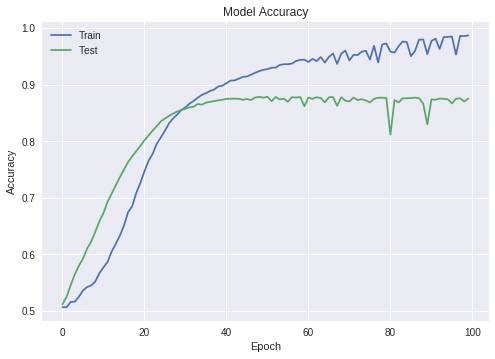

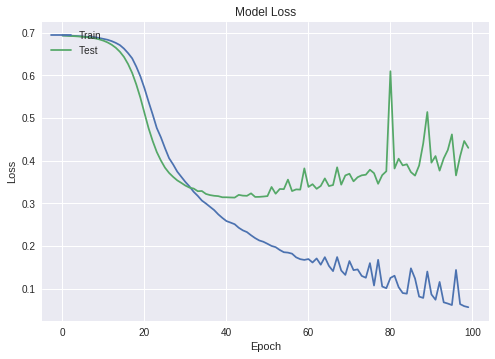

In [25]:
#Summarize history for accuracy
plt.plot(results3.history['acc'])
plt.plot(results3.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(results3.history['loss'])
plt.plot(results3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Results

###Model 1: Base model
Accuracy: 87.57%
Highest accuracy: 88.012%

###Model 2: Increasing input size and adding more layers
Accuracy: 87.24%
Highest accuracy: 87.968%

### Model 3: Revert to model 1 and increasing the layers and changing optimizer
Accuracy: 87.18%
Highest accuracy: 88.036%

## Conclusion:

Model 1 being the simplest and with very high accuracy may be the model to choose here. We think that we can still run a few more experiments by changing more hyperparameters and the design of the network to increase accuracy and get better performance. Given the limitation of time, we will go with the best model in the three experiments which is currently model 1.